In [ ]:
!pip install torch torchvision
!pip install transformers huggingface_hub
!pip install opencv-python matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/IDEA-Research/GroundingDINO.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-hg14bxbr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-hg14bxbr
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=55e8baefccfdc6166d06403fc0605dce9d6d618959d11858240e1ef6d7b16f4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-omfb_6us/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-cpo_axz4
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-cpo_axz4
  Resolved https://github.com/IDEA-Research/Gr

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth


--2025-09-28 12:47:21--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.87, 18.154.144.74, 18.154.144.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   378MB/s    in 0.9s    

2025-09-28 12:47:22 (378 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



In [ ]:
import os, json, torch, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
gdino_model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(gdino_model_id)
gdino_model = AutoModelForZeroShotObjectDetection.from_pretrained(gdino_model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

In [ ]:
gdino_model.eval()
gdino_model.to("cuda" if torch.cuda.is_available() else "cpu")

GroundingDinoForObjectDetection(
  (model): GroundingDinoModel(
    (backbone): GroundingDinoConvModel(
      (conv_encoder): GroundingDinoConvEncoder(
        (model): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0): SwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=128, out_features=128, bias=True)
                        (key): Linear(in_featu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sam_checkpoint = "/content/sam_vit_b.pth"  # path to downloaded checkpoint
sam_model_type = "vit_b"
sam_model = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint)
sam_model.to("cuda" if torch.cuda.is_available() else "cpu")
sam_predictor = SamPredictor(sam_model)  # initialize predictor

In [ ]:
img_path = "/content/drive/MyDrive/istockphoto-1478016720-612x612.jpg"  # change path to your image
image_pil = Image.open(img_path).convert("RGB")
image_np = np.array(image_pil)
print("Image loaded:", img_path, image_np.shape)

Image loaded: /content/drive/MyDrive/istockphoto-1478016720-612x612.jpg (408, 612, 3)


In [ ]:
prompt = "bus. person."  # objects to detect
inputs = processor(images=image_pil, text=prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    outputs = gdino_model(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]])
results = processor.post_process_grounded_object_detection(
    outputs,
    target_sizes=target_sizes,
    threshold=0.3
)

In [ ]:
sam_predictor.set_image(image_np)
masks = []
for box in results[0]["boxes"]:
    box = box.cpu().numpy()
    mask, _, _ = sam_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=False,
    )
    masks.append(mask[0])


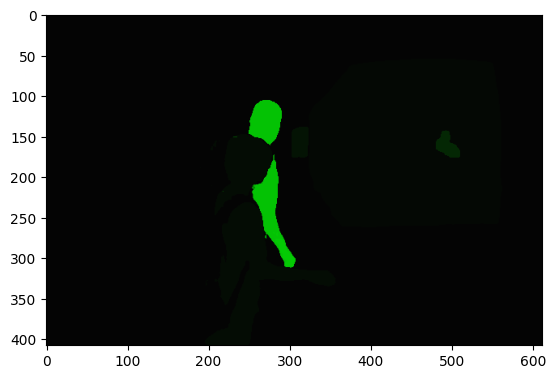

In [ ]:
for mask in masks:
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)
    colored_mask[mask] = (0, 255, 0)  # green overlay

    # expand mask to 3 channels
    mask_3ch = np.stack([mask]*3, axis=-1)
    plt.imshow(np.ma.masked_where(mask_3ch == 0, colored_mask), alpha=0.5)


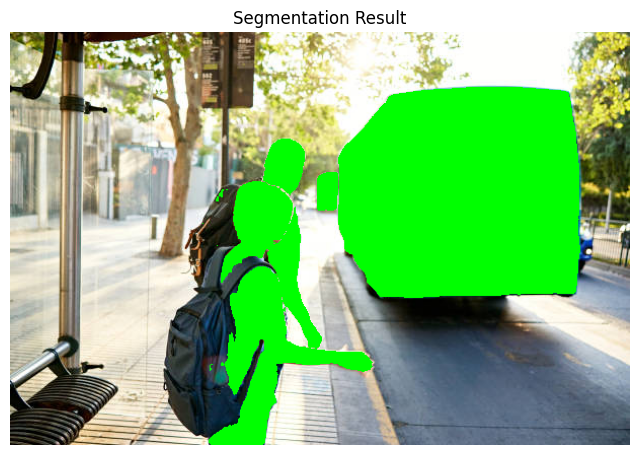

In [ ]:
overlay = image_np.copy()
for mask in masks:
    overlay[mask] = [0, 255, 0]  # green overlay
plt.figure(figsize=(8,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Segmentation Result")
plt.show()


/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


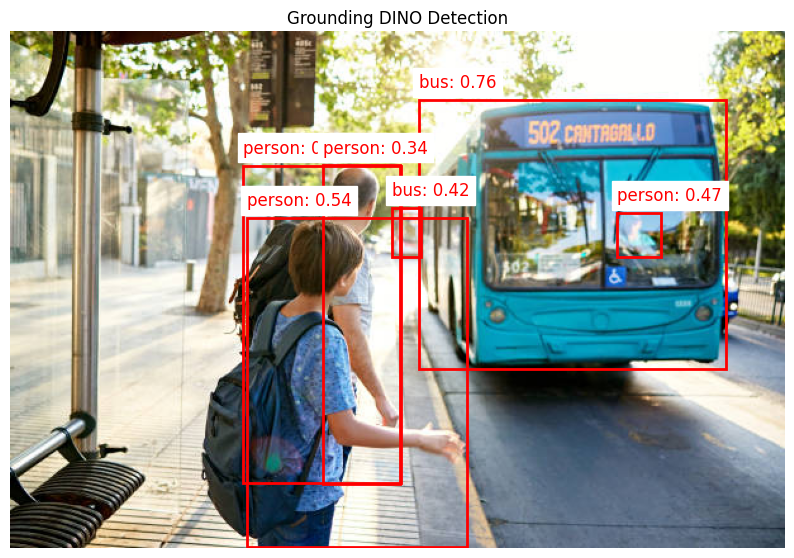

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image_np)
ax = plt.gca()

# Draw bounding boxes from Grounding DINO
for box, label, score in zip(results[0]["boxes"], results[0]["labels"], results[0]["scores"]):
    box = box.cpu().numpy()  # xyxy format
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    rect = patches.Rectangle(
        (x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1 - 10, f"{label}: {score:.2f}",
        color='red', fontsize=12, backgroundcolor='white'
    )

plt.axis("off")
plt.title("Grounding DINO Detection")
plt.show()


In [ ]:
img_path = "/content/drive/MyDrive/photo-1583847268964-b28dc8f51f92.jpg"  # change path to your image
image_pil = Image.open(img_path).convert("RGB")
image_np = np.array(image_pil)
print("Image loaded:", img_path, image_np.shape)

Image loaded: /content/drive/MyDrive/photo-1583847268964-b28dc8f51f92.jpg (4500, 3000, 3)


In [ ]:
prompt = "sofa. photoframe."
inputs = processor(images=image_pil, text=prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    outputs = gdino_model(**inputs)

target_sizes = torch.tensor([image_pil.size[::-1]])
results = processor.post_process_grounded_object_detection(
    outputs,
    target_sizes=target_sizes,
    threshold=0.3
)

In [ ]:
sam_predictor.set_image(image_np)
masks = []
for box in results[0]["boxes"]:
    box = box.cpu().numpy()
    mask, _, _ = sam_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=False,
    )
    masks.append(mask[0])

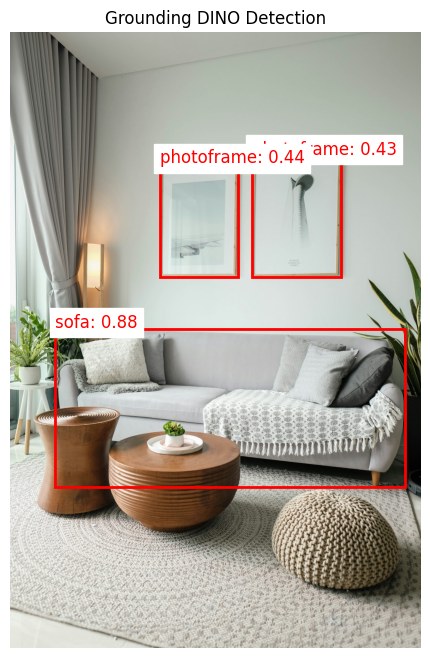

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(10, 8))
plt.imshow(image_np)
ax = plt.gca()

for box, label, score in zip(results[0]["boxes"], results[0]["labels"], results[0]["scores"]):
    box = box.cpu().numpy()
    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    rect = patches.Rectangle(
        (x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(
        x1, y1 - 10, f"{label}: {score:.2f}",
        color='red', fontsize=12, backgroundcolor='white'
    )

plt.axis("off")
plt.title("Grounding DINO Detection")
plt.show()